# Pipeline de Machine Learning - Tech Challenge 4

Este documento visa detalhar cada etapa do processo de análise de dados, feature engineering,
treinamento e escolha do modelo de machine learning para auxiliar médicos e médicas a prever 
se uma pessoa pode ter obesidade com base em seus hábitos e histórico familiar.

## Base de dados

Inicialmente será utilizada a base de dados disponibilizada para o desafio e encontrada em `./res/obesity.csv`.

### Dicionário de dados

A seguir está o dicionário de dados contendo a definição de cada coluna do arquivo `obesity.csv`.

| Coluna | Definição |
|-|-|
| Gender | Gênero |
| Age | Idade |
| Height | Altura em metros |
| Weight | Peso em quilogramas |
| family_history | Algum membro da família sofreu ou sofre de excesso de peso? <br>*(yes/no)* |
| FAVC | Você come alimentos altamente calóricos com frequência? <br>*(yes/no)* |
| FCVC | Frequência de consumo de vegetais. <br>*(escala de 1 a 3)* |
| NCP | Quantas refeições principais você faz diariamente? |
| CAEC | Frequência do consumo de alimento entre as refeições? <br>*(Never, Sometimes, Frequently, Always)* |
| SMOKE | Você fuma? <br>*(yes/no)* |
| CH2O | Quanta água você bebe diariamente? <br>*(escala de 1 a 3)* |
| SCC | Você monitora as calorias que ingere diariamente? <br>*(yes/no)* |
| FAF | Com que frequência você pratica atividade física? <br>*(escala de 0 a 3)* |
| TUE | Quanto tempo você usa dispositivos tecnológicos <br> como celular, videogame, televisão, computador e outros? <br>*(escala de 0 a 3)* |
| CALC | Com que frequência você bebe álcool? <br>*(Never, Sometimes, Frequently, Always)* |
| MTRANS | Qual meio de transporte você costuma usar? <br>*(Automobile, Bike, Motorbike, Public Transportation, Walking)*|
| **Obesity** <br> *(coluna alvo)* | Nível de obesidade <br>*(Insufficient Weight, Normal Weight, Overweight Level I, Overweight Level II, Obesity Type I, Obesity Type II, Obesity Type III)* |

## Importação de Bibliotecas

Importação das bibliotecas que serão utilizadas durante o desenvolvimento deste notebook.

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin 
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline


# Desabilitar warnings
import warnings
warnings.filterwarnings('ignore')

## Análise e Tratamento dos Dados

Análise inicial dos dados contidos no arquivo `obesity.csv` bem como o
tratamento inicial dos dados para padronização e utilização posterior no
modelo de ML.

### Leitura do arquivo e primeira impressões

In [3]:
obesity_data = pd.read_csv('./res/obesity.csv')
obesity_data.head()

,Gender,Age,Height,Weight,family_history,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Obesity
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


Verificando a quantidade de linhas e colunas do arquivo.

In [4]:
obesity_data.shape

(2111, 17)

Verificando dados nulos.

In [5]:
obesity_data.isnull().sum()

Gender            0
Age               0
Height            0
Weight            0
family_history    0
FAVC              0
FCVC              0
NCP               0
CAEC              0
SMOKE             0
CH2O              0
SCC               0
FAF               0
TUE               0
CALC              0
MTRANS            0
Obesity           0
dtype: int64

Transformando as colunas do tipo `yes/no` em valores numéricos, onde `1 = yes` e `0 = no`.

In [6]:
def transform_string_to_bool(df, columns):
  for column in columns:
    df[column] = df[column].replace({'yes': 1, 'no': 0})
  return df

In [7]:
obesity_data = transform_string_to_bool(obesity_data, ['family_history', 'FAVC', 'SMOKE', 'SCC'])
obesity_data.head()

,Gender,Age,Height,Weight,family_history,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Obesity
0,Female,21.0,1.62,64.0,1,0,2.0,3.0,Sometimes,0,2.0,0,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,1,0,3.0,3.0,Sometimes,1,3.0,1,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,1,0,2.0,3.0,Sometimes,0,2.0,0,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,0,0,3.0,3.0,Sometimes,0,2.0,0,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,0,0,2.0,1.0,Sometimes,0,2.0,0,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


Verificando os tipos de dados das colunas.

In [8]:
obesity_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Gender          2111 non-null   object 
 1   Age             2111 non-null   float64
 2   Height          2111 non-null   float64
 3   Weight          2111 non-null   float64
 4   family_history  2111 non-null   int64  
 5   FAVC            2111 non-null   int64  
 6   FCVC            2111 non-null   float64
 7   NCP             2111 non-null   float64
 8   CAEC            2111 non-null   object 
 9   SMOKE           2111 non-null   int64  
 10  CH2O            2111 non-null   float64
 11  SCC             2111 non-null   int64  
 12  FAF             2111 non-null   float64
 13  TUE             2111 non-null   float64
 14  CALC            2111 non-null   object 
 15  MTRANS          2111 non-null   object 
 16  Obesity         2111 non-null   object 
dtypes: float64(8), int64(4), object(5

Verificando dados descritivos (média, mediana, etc.)

In [9]:
obesity_data.describe()

,Age,Height,Weight,family_history,FAVC,FCVC,NCP,SMOKE,CH2O,SCC,FAF,TUE
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058,0.817622,0.883941,2.419043,2.685628,0.020843,2.008011,0.045476,1.010298,0.657866
std,6.345968,0.093305,26.191172,0.386247,0.320371,0.533927,0.778039,0.142893,0.612953,0.208395,0.850592,0.608927
min,14.000000,1.450000,39.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,19.947192,1.630000,65.473343,1.000000,1.000000,2.000000,2.658738,0.000000,1.584812,0.000000,0.124505,0.000000
50%,22.777890,1.700499,83.000000,1.000000,1.000000,2.385502,3.000000,0.000000,2.000000,0.000000,1.000000,0.625350
75%,26.000000,1.768464,107.430682,1.000000,1.000000,3.000000,3.000000,0.000000,2.477420,0.000000,1.666678,1.000000
max,61.000000,1.980000,173.000000,1.000000,1.000000,3.000000,4.000000,1.000000,3.000000,1.000000,3.000000,2.000000


Verificando a porcentagem dos valores descritivos e normalizando os valores, se necessário.

In [10]:
(obesity_data['CAEC'].value_counts(normalize = True) * 100).round(2)

CAEC
Sometimes     83.61
Frequently    11.46
Always         2.51
no             2.42
Name: proportion, dtype: float64

In [11]:
obesity_data['CAEC'].replace({'no': 'N/A'}, inplace=True)
(obesity_data['CAEC'].value_counts(normalize = True) * 100).round(2)

CAEC
Sometimes     83.61
Frequently    11.46
Always         2.51
N/A            2.42
Name: proportion, dtype: float64

In [12]:
(obesity_data['CALC'].value_counts(normalize = True) * 100).round(2)

CALC
Sometimes     66.37
no            30.27
Frequently     3.32
Always         0.05
Name: proportion, dtype: float64

In [13]:
obesity_data['CALC'].replace({'no': 'Never'}, inplace=True)
(obesity_data['CALC'].value_counts(normalize = True) * 100).round(2)

CALC
Sometimes     66.37
Never         30.27
Frequently     3.32
Always         0.05
Name: proportion, dtype: float64

In [14]:
(obesity_data['MTRANS'].value_counts(normalize = True) * 100).round(2)

MTRANS
Public_Transportation    74.85
Automobile               21.65
Walking                   2.65
Motorbike                 0.52
Bike                      0.33
Name: proportion, dtype: float64

In [15]:
obesity_data['MTRANS'] = obesity_data['MTRANS'].str.replace('_', ' ', regex=False)
(obesity_data['MTRANS'].value_counts(normalize = True) * 100).round(2)

MTRANS
Public Transportation    74.85
Automobile               21.65
Walking                   2.65
Motorbike                 0.52
Bike                      0.33
Name: proportion, dtype: float64

In [16]:
(obesity_data['Obesity'].value_counts(normalize = True) * 100).round(2)

Obesity
Obesity_Type_I         16.63
Obesity_Type_III       15.35
Obesity_Type_II        14.07
Overweight_Level_I     13.74
Overweight_Level_II    13.74
Normal_Weight          13.60
Insufficient_Weight    12.88
Name: proportion, dtype: float64

In [17]:
obesity_data['Obesity'] = obesity_data['Obesity'].str.replace('_', ' ', regex=False)
(obesity_data['Obesity'].value_counts(normalize = True) * 100).round(2)

Obesity
Obesity Type I         16.63
Obesity Type III       15.35
Obesity Type II        14.07
Overweight Level I     13.74
Overweight Level II    13.74
Normal Weight          13.60
Insufficient Weight    12.88
Name: proportion, dtype: float64

Verificando a correlação entre as variáveis numéricas.

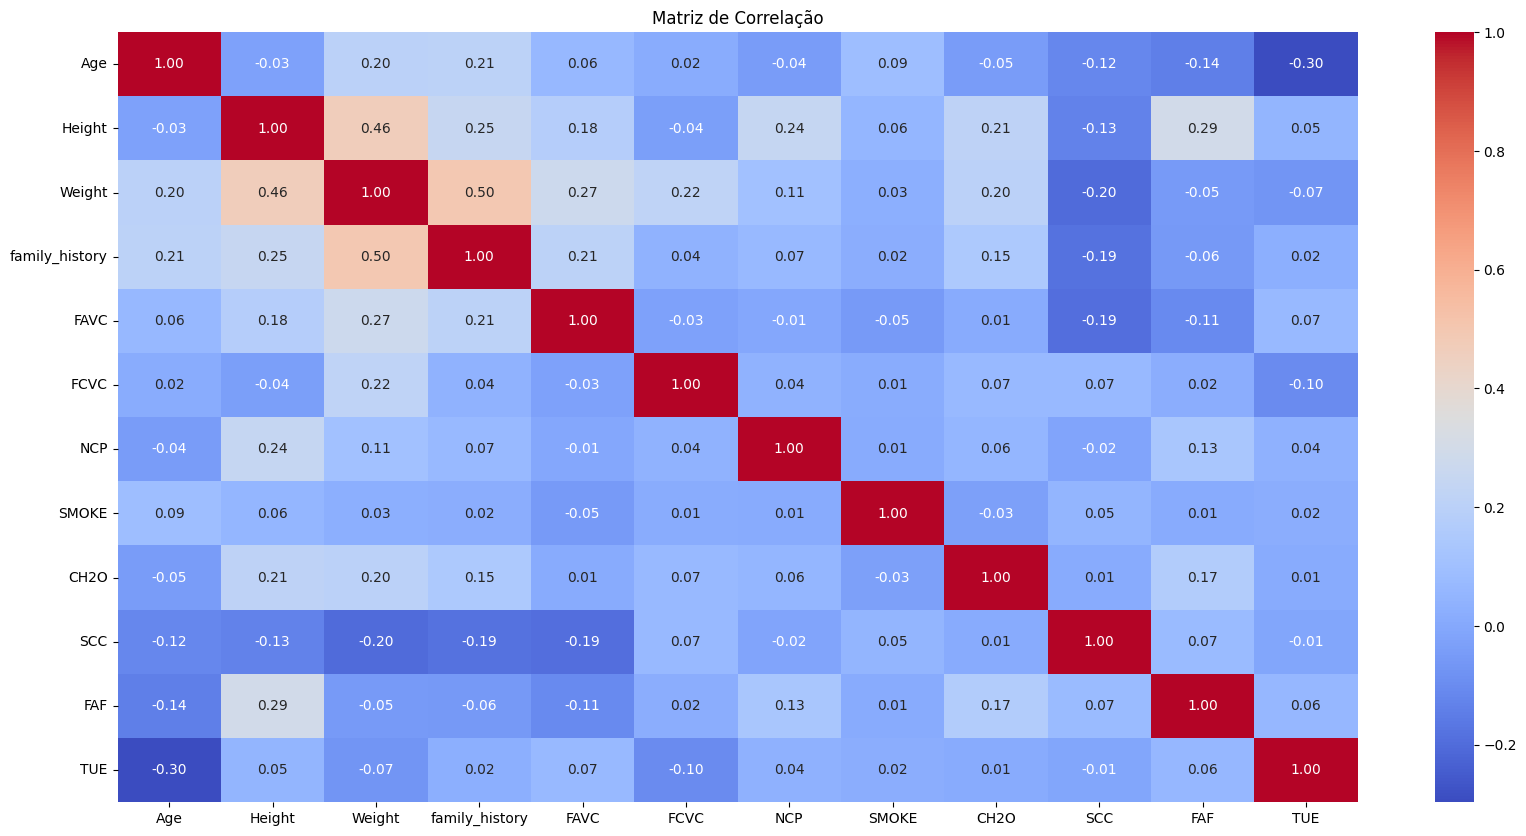

In [18]:
corr = obesity_data.select_dtypes(include='number').corr()
plt.figure(figsize=(20, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Matriz de Correlação')
plt.show()

## Feature Engineering

### Criação de novas features

Faixa etária.

In [19]:
def faixa_etaria(age):
  if age < 12:
    return 'Criança'
  elif age < 18:
    return 'Adolescente'
  elif age < 30:
    return 'Jovem Adulto'
  elif age < 60:
    return 'Adulto'
  else:
    return 'Idoso'

obesity_data['faixa_etaria'] = obesity_data['Age'].apply(faixa_etaria)
(obesity_data['faixa_etaria'].value_counts(normalize = True) * 100).round(2)

faixa_etaria
Jovem Adulto    77.40
Adulto          17.20
Adolescente      5.35
Idoso            0.05
Name: proportion, dtype: float64

É ou não obeso. Será utilizada na predição do modelo para definir se uma pessoa tem ou não a probabilidade de ser obesa.

Para isso, vamos considerar as seguintes entradas para definir se a pessoa é obesa: `Obesity Type I`, `Obesity Type II`, `Obesity Type III`

O resultado será uma coluna nova, com `1 = obeso` e `0 = não obeso`

In [121]:
# Criando coluna binária
obesity_data['is_obese'] = obesity_data['Obesity'].isin([
    "Obesity Type I",
    "Obesity Type II",
    "Obesity Type III"
]).astype(int)

obesity_data

,Gender,Age,Height,Weight,family_history,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Obesity,faixa_etaria,is_obese
0,Female,21.000000,1.620000,64.000000,1,0,2.0,3.0,Sometimes,0,2.000000,0,0.000000,1.000000,Never,Public Transportation,Normal Weight,Jovem Adulto,0
1,Female,21.000000,1.520000,56.000000,1,0,3.0,3.0,Sometimes,1,3.000000,1,3.000000,0.000000,Sometimes,Public Transportation,Normal Weight,Jovem Adulto,0
2,Male,23.000000,1.800000,77.000000,1,0,2.0,3.0,Sometimes,0,2.000000,0,2.000000,1.000000,Frequently,Public Transportation,Normal Weight,Jovem Adulto,0
3,Male,27.000000,1.800000,87.000000,0,0,3.0,3.0,Sometimes,0,2.000000,0,2.000000,0.000000,Frequently,Walking,Overweight Level I,Jovem Adulto,0
4,Male,22.000000,1.780000,89.800000,0,0,2.0,1.0,Sometimes,0,2.000000,0,0.000000,0.000000,Sometimes,Public Transportation,Overweight Level II,Jovem Adulto,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Female,20.976842,1.710730,131.408528,1,1,3.0,3.0,Sometimes,0,1.728139,0,1.676269,0.906247,Sometimes,Public Transportation,Obesity Type III,Jovem Adulto,1
2107,Female,21.982942,1.748584,133.742943,1,1,3.0,3.0,Sometimes,0,2.005130,0,1.341390,0.599270,Sometimes,Public Transportation,Obesity Type III,Jovem Adulto,1
2108,Female,22.524036,1.752206,133.689352,1,1,3.0,3.0,Sometimes,0,2.054193,0,1.414209,0.646288,Sometimes,Public Transportation,Obesity Type III,Jovem Adulto,1
2109,Female,24.361936,1.739450,133.346641,1,1,3.0,3.0,Sometimes,0,2.852339,0,1.139107,0.586035,Sometimes,Public Transportation,Obesity Type III,Jovem Adulto,1


## Construção da Pipeline

In [125]:
SEED = 42

In [126]:
df_train, df_test = train_test_split(obesity_data, test_size=0.2, random_state=SEED)

In [127]:
df_train.shape, df_test.shape

((1688, 19), (423, 19))

In [128]:
df_train.head()

,Gender,Age,Height,Weight,family_history,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Obesity,faixa_etaria,is_obese
162,Female,21.000000,1.630000,60.000000,1,1,3.000000,3.000000,Always,1,2.000000,0,2.000000,0.000000,Sometimes,Public Transportation,Normal Weight,Jovem Adulto,0
2001,Female,20.924956,1.752531,133.618706,1,1,3.000000,3.000000,Sometimes,0,2.887659,0,1.480919,0.779641,Sometimes,Public Transportation,Obesity Type III,Jovem Adulto,1
1435,Female,22.899740,1.661715,82.595793,1,1,1.203754,1.355354,Sometimes,0,2.765593,0,0.128342,1.659476,Sometimes,Public Transportation,Obesity Type I,Jovem Adulto,1
649,Female,21.837996,1.588046,44.236067,0,0,3.000000,1.696080,Frequently,0,2.550307,0,1.098862,0.000000,Never,Public Transportation,Insufficient Weight,Jovem Adulto,0
1280,Male,25.994746,1.811602,106.042142,1,1,3.000000,3.000000,Sometimes,0,2.858171,0,1.813318,0.680215,Sometimes,Public Transportation,Obesity Type I,Jovem Adulto,1


### Classes auxiliares

Drop nas seguintes feautres: `Obesity`

In [129]:
class DropFeatures(BaseEstimator,TransformerMixin):
    def __init__(self,feature_to_drop = ['Obesity']):
        self.feature_to_drop = feature_to_drop
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feature_to_drop).issubset(df.columns)):
            df.drop(self.feature_to_drop,axis=1,inplace=True)
            return df
        else:
            print('Uma ou mais features não estão no DataFrame')
            return df

Realizar o `MinMax Scaler` das features que possuem números "abertos", como `Age`, `Height`, `Weight`.

In [130]:
class MinMax(BaseEstimator,TransformerMixin):
  def __init__(self,min_max_scaler  = ['Age', 'Height', 'Weight']):
    self.min_max_scaler = min_max_scaler 
  def fit(self,df):
    return self
  def transform(self,df):
    if (set(self.min_max_scaler ).issubset(df.columns)):
      min_max_enc = MinMaxScaler()
      df[self.min_max_scaler] = min_max_enc.fit_transform(df[self.min_max_scaler ])
      return df
    else:
      print('MinMax > Uma ou mais features não estão no DataFrame')
      return df

Realizar o `OneHotEncoding` das features do tipo string, como `Gender`, `CAEC`, `CALC`, `MTRANS`, `faixa_etaria`.

In [131]:
class OneHotEncodingNames(BaseEstimator,TransformerMixin):
  def __init__(self,OneHotEncoding = ['Gender', 'MTRANS']):
    self.OneHotEncoding = OneHotEncoding

  def fit(self,df):
    return self

  def transform(self,df):
    if (set(self.OneHotEncoding).issubset(df.columns)):
      # função para one-hot-encoding das features
      def one_hot_enc(df,OneHotEncoding):
        one_hot_enc = OneHotEncoder()
        one_hot_enc.fit(df[OneHotEncoding])
        # obtendo o resultado dos nomes das colunas
        feature_names = one_hot_enc.get_feature_names_out(OneHotEncoding)
        # mudando o array do one hot encoding para um dataframe com os nomes das colunas
        df = pd.DataFrame(one_hot_enc.transform(df[self.OneHotEncoding]).toarray(),
                          columns= feature_names,index=df.index)
        return df

      # função para concatenar as features com aquelas que não passaram pelo one-hot-encoding
      def concat_with_rest(df,one_hot_enc_df,OneHotEncoding):              
        # get the rest of the features
        outras_features = [feature for feature in df.columns if feature not in OneHotEncoding]
        # concaternar o restante das features com as features que passaram pelo one-hot-encoding
        df_concat = pd.concat([one_hot_enc_df, df[outras_features]],axis=1)
        return df_concat

      # one hot encoded dataframe
      df_OneHotEncoding = one_hot_enc(df,self.OneHotEncoding)

      # retorna o dataframe concatenado
      df_full = concat_with_rest(df, df_OneHotEncoding,self.OneHotEncoding)
      return df_full

    else:
      print('OneHotEncodingNames > Uma ou mais features não estão no DataFrame')
      return df

In [132]:
class OrdinalFeature(BaseEstimator, TransformerMixin):
  def __init__(self):
    self.mappings = {
        'CAEC': ['Never', 'Sometimes', 'Frequently', 'Always'],
        'CALC': ['Never', 'Sometimes', 'Frequently', 'Always'],
        'faixa_etaria': ['Criança', 'Adolescente', 'Jovem Adulto', 'Adulto', 'Idoso']
    }
      
  def fit(self, X, y=None):
    return self
  
  def transform(self, X):
    X = X.copy()
    
    for col, order in self.mappings.items():
      if col in X.columns:
        X[col] = pd.Categorical(X[col], categories=order, ordered=True).codes
    
    return X


### Pipeline

In [133]:
def pipeline(df):

  pipeline = Pipeline([
    ('feature_dropper', DropFeatures()),
    ('OneHotEncoding', OneHotEncodingNames()),
    ('ordinal_feature', OrdinalFeature()),
    ('min_max_scaler', MinMax()),
    # ('oversample', Oversample())
  ])
  df_pipeline = pipeline.fit_transform(df)
  return df_pipeline

## Escolha do modelo

Utilizar uma cópia dos dados de treino para não perder informações que estão no DF original.

In [134]:
train = pipeline(df_train.copy())

In [135]:
train.head()

,Gender_Female,Gender_Male,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public Transportation,MTRANS_Walking,Age,Height,Weight,...,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,faixa_etaria,is_obese
162,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.148936,0.339623,0.156716,...,3.000000,3,1,2.000000,0,2.000000,0.000000,1,2,0
2001,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.147339,0.570813,0.706110,...,3.000000,1,0,2.887659,0,1.480919,0.779641,1,2,1
1435,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.189356,0.399462,0.325342,...,1.355354,1,0,2.765593,0,0.128342,1.659476,1,2,1
649,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.166766,0.260464,0.039075,...,1.696080,2,0,2.550307,0,1.098862,0.000000,0,2,0
1280,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.255207,0.682268,0.500314,...,3.000000,1,0,2.858171,0,1.813318,0.680215,1,2,1


In [136]:
test = pipeline(df_test.copy())

In [137]:
test.head()

,Gender_Female,Gender_Male,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public Transportation,MTRANS_Walking,Age,Height,Weight,...,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,faixa_etaria,is_obese
544,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.138991,0.662519,0.115791,...,3.891994,2,0,1.863930,0,2.870127,2.000000,0,2,0
1987,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.315397,0.372802,0.589608,...,3.000000,1,0,2.704315,0,0.000000,0.322666,1,2,1
420,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.063079,0.870411,0.167885,...,4.000000,1,0,2.000000,1,2.000000,0.000000,1,2,0
527,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.157698,0.140746,0.019056,...,1.000000,2,0,1.000000,0,0.000000,0.000000,1,2,0
196,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.189238,0.649301,0.283641,...,3.000000,1,0,2.000000,0,1.000000,2.000000,1,2,0


Definindo os dados de treino para o modelo

In [138]:
X_train, y_train = train.loc[:, train.columns != 'is_obese'], train['is_obese']
X_test, y_test= test.loc[:, test.columns != 'is_obese'], test['is_obese']

In [139]:
from sklearn import metrics
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay 
from scipy import stats
import numpy as np

In [143]:
SEED = 42

def roda_modelo(modelo):
    # Treina o modelo
    modelo.fit(X_train, y_train)

    # Probabilidade prevista
    prob_predic = modelo.predict_proba(X_test)

    print(f"\n------------------------------Resultados {modelo}------------------------------\n")

    # =====================
    #       AUC
    # =====================
    # Problema binário
    if len(np.unique(y_test)) == 2:
        auc = roc_auc_score(y_test, prob_predic[:, 1])
    else:  # Multiclasse
        auc = roc_auc_score(y_test, prob_predic, multi_class='ovr')
    
    print(f"AUC: {auc}")

    # =====================
    #        KS
    # =====================
    if len(np.unique(y_test)) == 2:
        data_bom = np.sort(prob_predic[:, 0])
        data_mau = np.sort(prob_predic[:, 1])
        kstest = stats.ks_2samp(data_bom, data_mau)
        print(f"Métrica KS: {kstest}")
    else:
        print("KS só é aplicável para problemas binários.")

    # =====================
    #   Matriz de Confusão
    # =====================
    print("\nConfusion Matrix\n")
    fig, ax = plt.subplots(figsize=(7,7))

    ConfusionMatrixDisplay.from_estimator(
        modelo,
        X_test,
        y_test,
        normalize='true',
        display_labels=['Obeso', 'Não obeso'] if len(np.unique(y_test)) == 2 else modelo.classes_,
        cmap=plt.cm.Blues,
        ax=ax
    )

    ax.set_title("Matriz de Confusão Normalizada", fontsize=16, fontweight="bold")
    ax.set_xlabel("Label predita", fontsize=18)
    ax.set_ylabel("Label verdadeira", fontsize=18)
    plt.grid(False)
    plt.show()

    # =====================
    # Classification Report
    # =====================
    predicao = modelo.predict(X_test)
    print("\nClassification Report")
    print(classification_report(y_test, predicao, zero_division=0))

    # =====================
    #       ROC CURVE
    # =====================
    print("\nRoc Curve\n")

    RocCurveDisplay.from_estimator(
        modelo,
        X_test,
        y_test,
        name="ROC Curve"
    )
    
    # y_proba = modelo.predict_proba(X_test)
    # classes = modelo.classes_

    # plt.figure(figsize=(10, 8))

    # for i, classe in enumerate(classes):
    #     RocCurveDisplay.from_predictions(
    #         (y_test == classe).astype(int),   # classe X vs resto
    #         y_proba[:, i],                    # prob dessa classe
    #         name=f"Classe {classe}"
    #     )

    # plt.title("Curva ROC Multiclasse (One-vs-Rest)")
    plt.show()


In [141]:
from sklearn.linear_model import LogisticRegression
modelo_logistico = LogisticRegression()


------------------------------Resultados LogisticRegression()------------------------------

AUC: 0.9975323043790381
Métrica KS: KstestResult(statistic=np.float64(0.09456264775413711), pvalue=np.float64(0.04547740728071966), statistic_location=np.float64(0.9720061624316971), statistic_sign=np.int8(-1))

Confusion Matrix



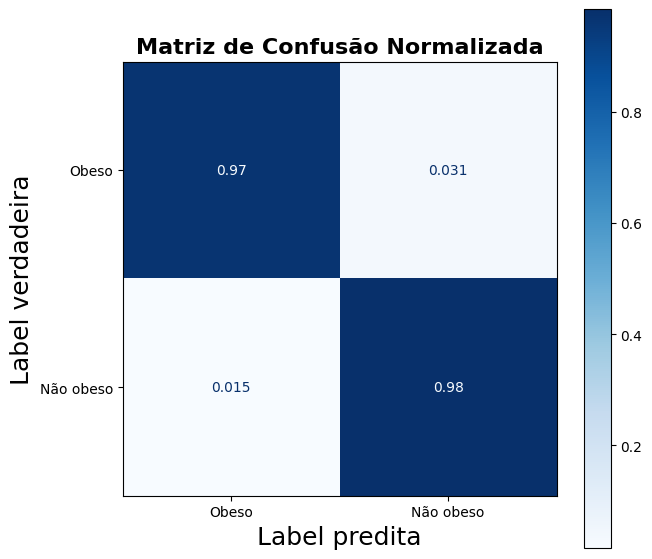


Classification Report
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       224
           1       0.97      0.98      0.98       199

    accuracy                           0.98       423
   macro avg       0.98      0.98      0.98       423
weighted avg       0.98      0.98      0.98       423


Roc Curve



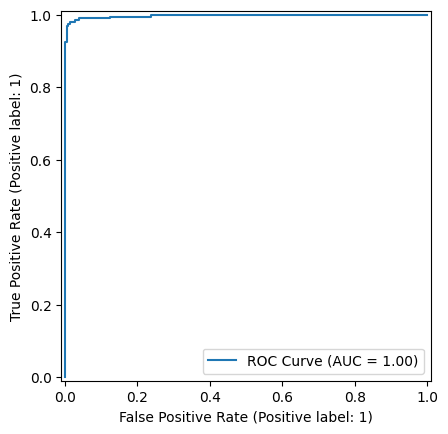

In [144]:
roda_modelo(modelo_logistico)